### REAL-TIME KEY-WORD RECOGNITION SPEECH INFERENCE
### ARUNWAT MOONBUNG (SHOICHI)

In [ ]:
# https://www.xilinx.com/htmldocs/vitis_ai/1_4/deploying_running.html

In [1]:
# IMPORT GENERAL MODULES
import argparse
from ctypes import *
import json
import math
import os
import sys
import scipy.misc 
import threading
import time
from typing import List
import vart
import wave
import xir

# IMPORT DATA PRE-PROCESSING MODULES
import alsaaudio
import cv2
import librosa, librosa.display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from playsound import playsound
from sklearn.preprocessing import StandardScaler,MinMaxScaler,LabelBinarizer

# IMPORT TENSORFLOW x Xilinx VITIS MODULES
# import tensorflow as tf
# import tensorflow.keras as keras

## ORIGINAL CODE DEBUGGING ZONE

In [2]:
def get_script_directory():
    path = os.getcwd()
    return path

SCRIPT_DIR = get_script_directory()
calib_image_dir = SCRIPT_DIR + "/images/"
xmodel_path = "resnet50test/resnet50.xmodel"
global threadnum
threadnum = 0
print(f"PATH OF SCRIPT_DIR: {SCRIPT_DIR}")
print(f"PATH OF calib_image_dir: {calib_image_dir}")
print(f"PATH OF x_model: {xmodel_path}")

PATH OF SCRIPT_DIR: /home/root/SpeechControlTH
PATH OF calib_image_dir: /home/root/SpeechControlTH/images/
PATH OF x_model: resnet50test/resnet50.xmodel


In [3]:
"""
pre-process for resnet50 (caffe)
"""
_B_MEAN = 104.0
_G_MEAN = 107.0
_R_MEAN = 123.0
MEANS = [_B_MEAN, _G_MEAN, _R_MEAN]
SCALES = [1.0, 1.0, 1.0]

def preprocess_one_image_fn(image_path, fix_scale, width=224, height=224):
    means = MEANS
    scales = SCALES
    image = cv2.imread(image_path)
    image = cv2.resize(image, (width, height))
    B, G, R = cv2.split(image)
    B = (B - means[0]) * scales[0] * fix_scale
    G = (G - means[1]) * scales[1] * fix_scale
    R = (R - means[2]) * scales[2] * fix_scale
    image = cv2.merge([B, G, R])
    image = image.astype(np.int8)
    return image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


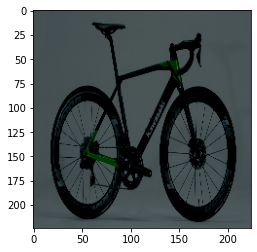

In [4]:
testimg = preprocess_one_image_fn("images/testimg1.jpg", 0.7)
imgtest = testimg[...,::-1]
plt.imshow(imgtest)

In [5]:
'''
ignored = {"folder_one", "folder_two", "folder_three"}
folders = [x for x in os.listdir(path) if x not in ignored]
'''
# REQUIED IF MODEL DOESN'T HAVE LAST SOFTMAX AS AN OUTPUT? BUT HOW?
def CPUCalcSoftmax(data, size, scale):
    sum = 0.0
    result = [0 for i in range(size)]
    for i in range(size):
        result[i] = math.exp(data[i] * scale)
        sum += result[i]
    for i in range(size):
        result[i] /= sum
    return result

# CLASS MAPPING FROM SOFTMAX
def TopK(datain, size, filePath):
    cnt = [i for i in range(size)]
    pair = zip(datain, cnt)
    pair = sorted(pair, reverse=True)
    softmax_new, cnt_new = zip(*pair)
    fp = open(filePath, "r")
    data1 = fp.readlines()
    fp.close()
    for i in range(1): # DEFAULT PRINT TOP 5
        idx = 0
        for line in data1:
            if idx == cnt_new[i]:
                print("Top[%d] %d %s" % (i, idx, (line.strip)("\n")))
            idx = idx + 1

# RUNNING INFERENCE?
def runResnet50(runner: "Runner", img, cnt):
    """get tensor"""
    inputTensors = runner.get_input_tensors()
    outputTensors = runner.get_output_tensors()
    input_ndim = tuple(inputTensors[0].dims)
    pre_output_size = int(outputTensors[0].get_data_size() / input_ndim[0])

    output_ndim = tuple(outputTensors[0].dims)
    output_fixpos = outputTensors[0].get_attr("fix_point")
    output_scale = 1 / (2**output_fixpos)
    n_of_images = len(img)
    count = 0
    while count < cnt:
        runSize = input_ndim[0]
        """prepare batch input/output """
        inputData = [np.empty(input_ndim, dtype=np.int8, order="C")]
        outputData = [np.empty(output_ndim, dtype=np.int8, order="C")]
        """init input image to input buffer """
        for j in range(runSize):
            imageRun = inputData[0]
            imageRun[j, ...] = img[(count + j) % n_of_images].reshape(input_ndim[1:])
        """run with batch """
        job_id = runner.execute_async(inputData, outputData)
        runner.wait(job_id)
        """softmax&TopK calculate with batch """
        """Benchmark DPU FPS performance over Vitis AI APIs execute_async() and wait() """
        """Uncomment the following code snippet to include softmax calculation for model’s end-to-end FPS evaluation """
        for j in range(runSize):
            softmax = CPUCalcSoftmax(outputData[0][j], pre_output_size, output_scale)
            TopK(softmax, pre_output_size, "words.txt")
        count = count + runSize

def get_child_subgraph_dpu(graph: "Graph") -> List["Subgraph"]:
    assert graph is not None, "'graph' should not be None."
    root_subgraph = graph.get_root_subgraph()
    assert (root_subgraph
            is not None), "Failed to get root subgraph of input Graph object."
    if root_subgraph.is_leaf:
        return []
    child_subgraphs = root_subgraph.toposort_child_subgraph()
    assert child_subgraphs is not None and len(child_subgraphs) > 0
    return [
        cs for cs in child_subgraphs
        if cs.has_attr("device") and cs.get_attr("device").upper() == "DPU"
    ]

In [14]:
##############################################
# GLOBAL VARIABLES
##############################################
threadnum = 3 # NUMBER OF THREADS IN JOB
threadAll = [] # LIST OF ALL THREADS JOB
##############################################
# CREATE DPU RUNNER DEPEND ON NUMBER OF THREAD
##############################################
graph = xir.Graph.deserialize(xmodel_path)
subgraphs = get_child_subgraph_dpu(graph)
assert len(subgraphs) == 1, "!: ERROR: There should be only one DPU kernel."
all_dpu_runners = []
for i in range(int(threadnum)):
    all_dpu_runners.append(vart.Runner.create_runner(subgraphs[0], "run"))
print(f"#: ALL DPU RUNNERS HAS BEEN SUCCESSFULLY LOADED")
print(f"#: DPUs: {all_dpu_runners}")
##############################################
# PRE-PROCESSING | GET BATCH IMAGES DATA
##############################################
listImages = sorted(os.listdir(calib_image_dir))
img_input_batch = []
input_scale = 0.5
for idx, filename in enumerate(listImages):
    img_input_batch.append(preprocess_one_image_fn(os.path.join(calib_image_dir, filename), input_scale))
##############################################
# SETUP THE THREADS TO RUN THE DPU
##############################################
# CALCULATE IMAGES INDEX FOR ONE THREAD.
cnt = int(len(img_input_batch) / threadnum)
num_images_per_thread = int(len(img_input_batch)/threadnum) + 1
print(f"#: LIST IMAGES: {listImages}")
print(f"#: NUMBER OF IMAGES IN BATCH: {len(img_input_batch)}")
print(f"#: NUMBER OF IMAGES INPUT PER THREADS: {num_images_per_thread - 1}")
print(f"#: NUMBER OF THREADS ASSIGNED: {threadnum}")
print("")

time_start = time.time()
for i in range(threadnum): #threadnum
    startIdx = i * num_images_per_thread
    if ((len(listImages)-(i*num_images_per_thread)) > num_images_per_thread):
        endIdx = (i+1)*num_images_per_thread
    else:
        endIdx = len(listImages) # LAST INDEX DOESN'T COUNT IN PYTHON ONLY [START:END-1]
    if startIdx >= len(listImages):
        print(f"#: WARNING: THE NUMBER OF THREAD EXEEDS THE NUMBER OF DATA.")
        print(f"#: WARNING: THEREFORE, ONLY {i} USED IN THIS PROCESS.")
        break
    t1 = threading.Thread(target=runTest, args=(all_dpu_runners[i], img_input_batch[startIdx:endIdx], cnt))
    threadAll.append(t1)
for x in threadAll:
    x.start() # EXECUTE JOB ADD RUNNER FUNCTION AS EACH (SUB)THREAD
for x in threadAll:
    x.join() # MAKE MAIN THREAD WAIT UNTIL SUB THREAD FINISH THEIR JOB
del all_dpu_runners
time_end = time.time()
timetotal = time_end - time_start
total_frames = cnt * int(threadnum)
fps = float(total_frames / timetotal)
print("")
print(f"FPS: {fps:.2f}, Total Frames: {total_frames:.2f}, Time: {timetotal:.6f}sec")

#: ALL DPU RUNNERS HAS BEEN SUCCESSFULLY LOADED
#: DPUs: [vart::Runner@0xaaaadcac2b30, vart::Runner@0xaaaadccfb4f0, vart::Runner@0xaaaadcbdc6a0]
#: LIST IMAGES: ['testimg1.jpg', 'testimg10.jpg', 'testimg11.jpg', 'testimg12.jpg', 'testimg13.jpg', 'testimg14.jpg', 'testimg15.jpg', 'testimg2.jpg', 'testimg3.jpg', 'testimg4.jpg', 'testimg5.jpg', 'testimg6.jpg', 'testimg7.jpg', 'testimg8.jpg', 'testimg9.jpg']
#: NUMBER OF IMAGES IN BATCH: 15
#: NUMBER OF IMAGES INPUT PER THREADS: 5
#: NUMBER OF THREADS ASSIGNED: 3

input_ndim (1, 224, 224, 3)
pre_output_size 1000
output_ndim (1, 1000)
input_ndim (1, 224, 224, 3)
pre_output_size 1000
output_ndim (1, 1000)
input_ndim (1, 224, 224, 3)
pre_output_size 1000
output_ndim (1, 1000)
Top[0] 483 castle
Top[0] 671 mountain bike, all-terrain bike, off-roader
Top[0] 950 orange
Top[0] 504 coffee mugTop[0] 817 sports car, sport car

Top[0] 287 lynx, catamount
Top[0] 508 computer keyboard, keypad
Top[0] 356 weasel
Top[0] 546 electric guitar
Top[0] 281 tabby

In [6]:
##############################################
# ONE DPU RUNNER INFERENCE FUNCTION
##############################################
def runTest(runner: "Runner", img, cnt):
    """get tensor"""
    inputTensors = runner.get_input_tensors()
    outputTensors = runner.get_output_tensors()
    input_ndim = tuple(inputTensors[0].dims)
    print(f"input_ndim", input_ndim)
    pre_output_size = int(outputTensors[0].get_data_size() / input_ndim[0])
    print(f"pre_output_size", pre_output_size)
    output_ndim = tuple(outputTensors[0].dims)
    print(f"output_ndim", output_ndim)
    output_fixpos = outputTensors[0].get_attr("fix_point")
    #print(f"output_fixpos", output_fixpos)
    output_scale = 1 / (2**output_fixpos)
    #print(f"output_scale", output_scale)
    n_of_images = len(img)
    #print(f"n_of_images", n_of_images)
    count = 0
    
    while count < cnt: #cnt
        runSize = input_ndim[0] # FROM IMAGES DIMENSION BATCH
        #print(f"runSize", runSize)
        """prepare batch input/output """
        inputData = [np.zeros(input_ndim, dtype=np.int8, order="C")] #CREATE LIST OF EMPTY ARRAY SHAPE = (1,224,224,3)
        #print(f"inputData[0]", inputData[0].shape)
        #print(f"inputData[0]", inputData[0])
        outputData = [np.empty(output_ndim, dtype=np.int8, order="C")]
        #print(f"outputData[0]", outputData[0].shape)
        """init input image to input buffer """
        for j in range(runSize):
            inputData[0] = img[(count + j) % n_of_images] #.reshape(input_ndim[1:])
            inputData[0] = inputData[0][np.newaxis, ...]
            #imageRun = inputData[0]
            #print(f"imageRun", imageRun)
            #imageRun[j, ...] = img[(count + j) % n_of_images].reshape(input_ndim[1:]) #THIS LINE WILL CHANGE THE inputData with actual imgage array
            #print(f"imageRun2", imageRun)
        #print(f"NEW inputData[0]", inputData[0].shape)
        #print(f"NEW inputData[0]", inputData[0])
        """run with batch """
        job_id = runner.execute_async(inputData, outputData)
        runner.wait(job_id)
        #"""softmax&TopK calculate with batch """
        #"""Benchmark DPU FPS performance over Vitis AI APIs execute_async() and wait() """
        #"""Uncomment the following code snippet to include softmax calculation for model’s end-to-end FPS evaluation """
        for j in range(runSize):
            softmax = CPUCalcSoftmax(outputData[0][j], pre_output_size, output_scale)
            TopK(softmax, pre_output_size, "words.txt")
        count = count + runSize

In [7]:
##############################################
# CREATE A DPU RUNNER GRAPH
##############################################
graph = xir.Graph.deserialize(xmodel_path)
subgraphs = get_child_subgraph_dpu(graph)
assert len(subgraphs) == 1, "!: ERROR: There should be only one DPU kernel."
dpu_runner = vart.Runner.create_runner(subgraphs[0], "run")
print(f"#: A DPU RUNNER HAS BEEN SUCCESSFULLY LOADED")
print(f"#: DPU RUNNER: {dpu_runner}")
##############################################
# PRE-PROCESSING | GET BATCH IMAGES DATA
##############################################
listImages = sorted(os.listdir(calib_image_dir))
img_input_batch = []
input_scale = 0.5
for idx, filename in enumerate(listImages):
    img_input_batch.append(preprocess_one_image_fn(os.path.join(calib_image_dir, filename), input_scale))
##############################################
# RUN DPU INFERENCE
##############################################
print(f"#: START A DPU INFERENCE PROCESS")
cnt = len(img_input_batch)
runOnce(dpu_runner, img_input_batch, cnt)

#: A DPU RUNNER HAS BEEN SUCCESSFULLY LOADED
#: DPU RUNNER: vart::Runner@0xaaaae7e37b00
#: START A DPU INFERENCE PROCESS


In [6]:
##############################################
# ONE DPU RUNNER INFERENCE FUNCTION
##############################################
def runOnce(runner: "Runner", img, cnt):
    # INPUT / OUTPUT DIMENSION INFO
    inputTensors = runner.get_input_tensors()
    outputTensors = runner.get_output_tensors()
    input_ndim = tuple(inputTensors[0].dims) # (1, 224, 224, 3)
    output_ndim = tuple(outputTensors[0].dims) # (1, 1000)
    pre_output_size = int(outputTensors[0].get_data_size() / input_ndim[0]) # USE WITH SOFTMAX AND TOPK RETURN 1000
    # CUT LATER MAYBE NO USED
    output_fixpos = outputTensors[0].get_attr("fix_point")
    output_scale = 1 / (2**output_fixpos)
    #########################
    n_of_images = len(img)
    count = 0
    '''
    while count < cnt: #cnt
        runSize = input_ndim[0] # FROM IMAGES DIMENSION BATCH
        #print(f"runSize", runSize)
        """prepare batch input/output """
        inputData = [np.zeros(input_ndim, dtype=np.int8, order="C")] #CREATE LIST OF EMPTY ARRAY SHAPE = (1,224,224,3)
        #print(f"inputData[0]", inputData[0].shape)
        #print(f"inputData[0]", inputData[0])
        outputData = [np.empty(output_ndim, dtype=np.int8, order="C")]
        #print(f"outputData[0]", outputData[0].shape)
        """init input image to input buffer """
        for j in range(runSize):
            inputData[0] = img[(count + j) % n_of_images] #.reshape(input_ndim[1:])
            inputData[0] = inputData[0][np.newaxis, ...]
            #imageRun = inputData[0]
            #print(f"imageRun", imageRun)
            #imageRun[j, ...] = img[(count + j) % n_of_images].reshape(input_ndim[1:]) #THIS LINE WILL CHANGE THE inputData with actual imgage array
            #print(f"imageRun2", imageRun)
        #print(f"NEW inputData[0]", inputData[0].shape)
        #print(f"NEW inputData[0]", inputData[0])
        """run with batch """
        job_id = runner.execute_async(inputData, outputData)
        runner.wait(job_id)
        #"""softmax&TopK calculate with batch """
        #"""Benchmark DPU FPS performance over Vitis AI APIs execute_async() and wait() """
        #"""Uncomment the following code snippet to include softmax calculation for model’s end-to-end FPS evaluation """
        for j in range(runSize):
            softmax = CPUCalcSoftmax(outputData[0][j], pre_output_size, output_scale)
            TopK(softmax, pre_output_size, "words.txt")
        count = count + runSize'''

## MANUALLY PUT TOGETHER CODE

In [ ]:
def pad_audio_sec(signal, DURATION, NUM_SAMPLES_TO_CONSIDER):
        TOTAL_SAMPLE = DURATION*NUM_SAMPLES_TO_CONSIDER
        if len(signal) >= TOTAL_SAMPLE:
            return signal[:TOTAL_SAMPLE]
        else:
            #return np.pad(signal, pad_width=(0, TOTAL_SAMPLE - len(signal)), mode='constant', constant_values=(0, 0)) # PAD หลัง
            return np.pad(signal, pad_width=(TOTAL_SAMPLE - len(signal), 0), mode='constant', constant_values=(0, 0)) # PAD หน้า

def preprocess_data_test(file_path, DURATION=1, n_mfcc=40, n_fft=4096, hop_length=512, NUM_SAMPLES_TO_CONSIDER=16000):
    # CALCULATION FOR AUDIO FILES
    SAMPLES_PER_TRACK = NUM_SAMPLES_TO_CONSIDER * DURATION
    NUM_SAMPLES_PER_SEGMENT = int(SAMPLES_PER_TRACK/DURATION) # OR REPLACE DURATION WITH NUM_SEGMENTS
    EXPECTED_MFCC = math.ceil(NUM_SAMPLES_PER_SEGMENT / hop_length) # EXPECTED NUMBERS OF MFCCs PER SEGMENT
    # READ AUDIO FILE FROM .WAV FILE TO GET SIGNAL AND SR
    signal, sr = librosa.load(file_path, sr=NUM_SAMPLES_TO_CONSIDER)
    signal = pad_audio_sec(signal, DURATION, sr)
    scaler = StandardScaler()
    MFCCs_scaled = []
    for s in range(DURATION): # DURATION = NUM_SEGMENTS
        START_SAMPLE = int(NUM_SAMPLES_PER_SEGMENT * s)
        END_SAMPLE = int(START_SAMPLE + NUM_SAMPLES_PER_SEGMENT)
        MFCC = librosa.feature.mfcc(y=signal[START_SAMPLE:END_SAMPLE],
                                    sr=sr, n_mfcc=n_mfcc,
                                    hop_length=hop_length,n_fft=n_fft)
        MFCC = MFCC.T
        MFCC_scaled = scaler.fit_transform(MFCC)
        MFCC_scaled = MFCC_scaled.reshape(MFCC_scaled.shape[0], MFCC_scaled.shape[1], 1)
        #MFCC_scaled = MFCC_scaled[np.newaxis, ...]
        if len(MFCC) == EXPECTED_MFCC:
            MFCCs_scaled.append(MFCC_scaled)
        else:
            pass
    return MFCCs_scaled[0] # FIRST INDEX FOR 1sec # BEST PRACTICE

In [ ]:
soundwav = preprocess_data_test("cacheSound.wav")
print(soundwav.shape)
plt.imshow(soundwav)